In [6]:
!pip install cython

In [15]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-o100pad3
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-o100pad3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2898187 sha256=999359078b17ec10f1268bd15312d91f220a985165173e4bd2da9937822e333e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vcxc2dt_/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf


In [31]:
# !pip install -U cython

In [30]:
# !apt-get remove cython
# !pip install -U cython

In [29]:
# !apt-get update -y
# !apt-get install --reinstall build-essential -y

In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations import *
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.4.0
GPU 사용 가능 여부: True
Tesla P40
1


In [2]:
batch_size = 16   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
%matplotlib inline

dataset_path = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

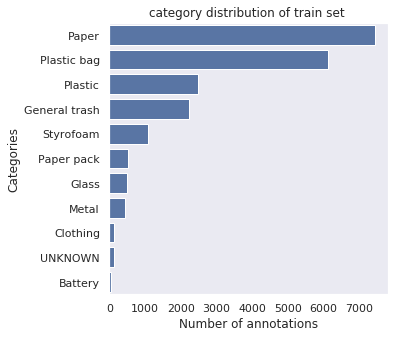

In [5]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [6]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [7]:
# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


In [8]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        paths = os.path.join(dataset_path, image_infos['file_name'])
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.uint8)
#         images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.uint8)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return paths,images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return paths, images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [9]:
train_path = dataset_path + '/train_all.json'

def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                            ToTensorV2()
                            ])

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=7.23s)
creating index...
index created!


In [10]:
img_dir = []

for step, (paths,images, masks, _) in enumerate(train_loader):
    img_dir.append(paths[0])

/opt/ml/input/data/batch_02_vt/1808.jpg


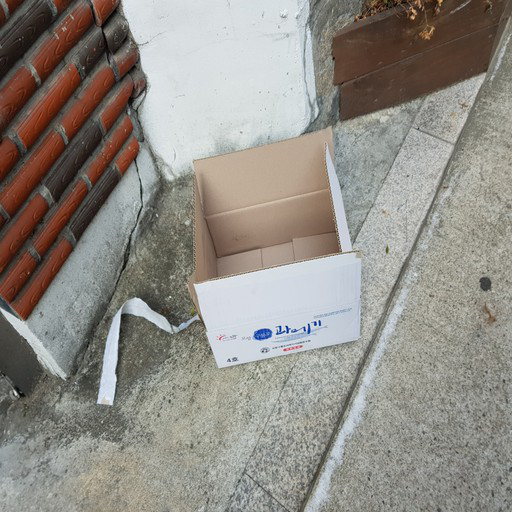

In [11]:
from tqdm.notebook import tqdm
from PIL import Image
print(img_dir[0])

Image.open(img_dir[0])

In [12]:
train_path = dataset_path + '/train_all.json'

def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
    Normalize(
        mean=(0.46009655,0.43957878,0.41827092), 
        std=(0.2108204,0.20766491,0.21656131), 
        max_pixel_value=255.0, 
        p=1.0),
    ToTensorV2()
])

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.33s)
creating index...
index created!


In [13]:
# train_loader의 output 결과(image 및 mask) 확인
for _,imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

In [33]:
img = temp_images

In [34]:
img = temp_images

In [35]:
# img = np.uint8(255 * img)

In [36]:
# img.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [37]:
predict = np.random.rand(8,12,512,512)

In [38]:
import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils
from tqdm.notebook import tqdm

MAX_ITER = 10

POS_W = 3
POS_XY_STD = 1
Bi_W = 4
Bi_XY_STD = 67
Bi_RGB_STD = 3

#Bi_W=4
#Bi_XY_STD=49
#Bi_RGB_STD=5

#POS_W=3
#POS_XY_STD=3

def dense_crf(t_img, t_output_probs):
    res = []
    
    for i in range(len(t_img)):
        img = t_img[i].numpy()
        img = np.uint8(255 * img)
        
        output_probs = t_output_probs[i]
        
        c = output_probs.shape[0]
        h = output_probs.shape[1]
        w = output_probs.shape[2]

        U = utils.unary_from_softmax(output_probs)
        U = np.ascontiguousarray(U)

        img = np.ascontiguousarray(img)

        d = dcrf.DenseCRF2D(w, h, c)
        d.setUnaryEnergy(U)
        d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
        d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img.reshape(512,512,3), compat=Bi_W)

        Q = d.inference(MAX_ITER)
        Q = np.array(Q).reshape((c, h, w))
        res.append(Q)
    return np.array(res)

In [39]:
import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils
from tqdm.notebook import tqdm

MAX_ITER = 10

POS_W = 3
POS_XY_STD = 1
Bi_W = 4
Bi_XY_STD = 67
Bi_RGB_STD = 3

#Bi_W=4
#Bi_XY_STD=49
#Bi_RGB_STD=5

#POS_W=3
#POS_XY_STD=3

def dense_crf(t_img, t_output_probs):
    res = []
    
    for i in tqdm(range(len(t_img))):
        img = t_img[i].numpy()
        img = np.uint8(255 * img)
        
        output_probs = t_output_probs[i]
        
        c = output_probs.shape[0]
        h = output_probs.shape[1]
        w = output_probs.shape[2]

        U = utils.unary_from_softmax(output_probs)
        U = np.ascontiguousarray(U)

        img = np.ascontiguousarray(img)

        d = dcrf.DenseCRF2D(w, h, c)
        d.setUnaryEnergy(U)
        d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
        d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img.reshape(512,512,3), compat=Bi_W)

        Q = d.inference(MAX_ITER)
        Q = np.array(Q).reshape((c, h, w))
        res.append(Q)
    return np.array(res)

In [40]:
o = dense_crf(img,predict)

  0%|          | 0/8 [00:00<?, ?it/s]

In [41]:
o.shape

(8, 12, 512, 512)

In [42]:
type(o)

numpy.ndarray

In [ ]:
# def dense_crf(img, output_probs):
#     c = output_probs.shape[0]
#     h = output_probs.shape[1]
#     w = output_probs.shape[2]

#     U = utils.unary_from_softmax(output_probs)
#     U = np.ascontiguousarray(U)

#     img = np.ascontiguousarray(img)

#     d = dcrf.DenseCRF2D(w, h, c)
#     d.setUnaryEnergy(U)
#     d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
#     d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W)

#     Q = d.inference(MAX_ITER)
#     Q = np.array(Q).reshape((c, h, w))
#     return Q 